In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from quetzal.model import stepmodel
from syspy.skims import skims
from quetzal.io import excel

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


# Modelling step assignment
## Needs LoS tables and logit probabilities
## Saves loaded network

In [3]:
input_path = '../input/'
network_path = '../input_static/'
output_path = '../output/'
model_path = '../model/' + scenario + '/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
# Create a path for output files and plots
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [6]:
sm = stepmodel.read_json(model_path + 'de_zones')

In [7]:
sm.segments = [s.strip() for s in params['general']['demand_segments'].split(';')]
purposes = [s.split('_')[0] for s in sm.segments][::2]

In [8]:
# Load volumes
volumes_file = 'de_volumes'
v = stepmodel.read_json(model_path + volumes_file)
# Rename columns from VP2030 to match the model's demand segments
car_segment_dict = {'0': '_no_car', '1': '_car'}
vp_purpose_dict = {'Fz1': 'commuting', 'Fz2': 'education', 'Fz3': 'buy/execute',
                   'Fz4': 'business', 'Fz6': 'leisure'}
sm.volumes = v.volumes.rename(columns={
    c: vp_purpose_dict[c.split('_')[0]]+car_segment_dict[c.split('_')[-1]]
    for c in v.volumes.columns if c.startswith('Fz')
})
# Create demand segment 'accompany' from 'Fz6' (private) with MiD2017 shares
accompany_no_car_share = 101 / 1530
accompany_car_share = 5569 / 30292
sm.volumes['accompany'+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * accompany_no_car_share
sm.volumes['accompany'+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * accompany_car_share
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['0']] * (1-accompany_no_car_share)
sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] = \
    sm.volumes[vp_purpose_dict['Fz6']+car_segment_dict['1']] * (1-accompany_car_share)

In [9]:
# Load LoS tables with mode choice probabilities
car = stepmodel.read_json(model_path + 'de_road_los')
pt = stepmodel.read_json(model_path + 'de_pt_los')

In [10]:
# Rename columns that were confused through json export
column_dict = {col: eval(col) for col in pt.pt_los.columns if 'probability' in col}
sm.pt_los = pt.pt_los.rename(columns=column_dict)
sm.car_los = car.car_los.rename(columns=column_dict)

In [11]:
# Make path to tuples as workaround for pandas TypeError
# (see issue: https://github.com/pandas-dev/pandas/issues/31177)
sm.pt_los['link_path'] = sm.pt_los['link_path'].apply(lambda p: tuple(p))
sm.car_los['link_path'] = sm.car_los['link_path'].apply(lambda p: tuple(p))

In [12]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,...,"(business_no_car, probability)","(business_car, probability)","(education_no_car, probability)","(education_car, probability)","(buy/execute_no_car, probability)","(buy/execute_car, probability)","(leisure_no_car, probability)","(leisure_car, probability)","(accompany_no_car, probability)","(accompany_car, probability)"
index,,,,,,,,,,,,,,,,,,,,,
1278982,DE216_5,DE925_2,"[air, rail_short]","(rs_35898, rs_35899, rs_35900, rs_35901, rs_35...",5,833883,1471,1127,16860,7000,...,0.021234,0.086957,2.592000e-07,0.000002,0.000025,0.000024,0.000027,0.003084,2.140000e-08,6.000000e-10


In [13]:
# Concat the LoS tables
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index()

## Assignment

The current volumes table contains outward and return trips per OD pair.

In [14]:
# Assign volumes to LoS path table
sm.los.drop(sm.segments + [c for c in sm.los.columns
                           if 'utility' in c or 'price' in c or ('time' in c and len(c)>4)],
            axis=1, inplace=True, errors='ignore')
sm.compute_los_volume(keep_segments=True)
sm.pt_los = sm.los.loc[sm.los['route_type']!='car']
sm.car_los = sm.los.loc[sm.los['route_type']=='car']

In [15]:
sm.los.sample()

,index,origin,destination,route_types,link_path,ntransfers,length,time,route_type,path,...,business_car,education_no_car,education_car,buy/execute_no_car,buy/execute_car,leisure_no_car,leisure_car,accompany_no_car,accompany_car,volume
3182703,3182703,DE258_5,DE932_1,"[air, rail_short, bus]","(bus_934542, rs_52789, rs_52790, rs_52791, rs_...",4.0,504948,4.568333,air,None,...,0.084795,0.0,0.0,0.0,0.0,0.000098,0.253142,0.000941,0.000014,0.339979


### Validation

In [24]:
# Load calibration dataset for modal split validation
mid_val = pd.read_csv(network_path + 'mid2017_validation_normalised.csv')
mid_val.set_index('mode_model', drop=True, inplace=True)
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid_val['mode_agg'] = [mode_dict_mid[i] for i in mid_val.index]

In [32]:
# Load VP2030 data for validation
vp2017 = pd.read_csv(network_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017 = vp2017.groupby(['origin', 'destination']).sum()
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}
vp2017.columns = pd.MultiIndex.from_tuples(
    [(col.split('_')[-1], mode_dict_vp[col.split('_')[0]]) for col in vp2017.columns],
    names=['segment', 'mode'])

In [68]:
p_dict = dict(zip(vp_purpose_dict.values(), vp_purpose_dict.keys()))

In [65]:
# Define distance classes
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 100, 150, 300, 1000]
distances = sm.car_los.groupby(['origin', 'destination']).agg({'length': 'mean'}) / 1000
island_dict = sm.zones.loc[['outer_1', 'outer_2'], 'NUTS_ID'].to_dict()
sm.car_los['o'] = sm.car_los['origin'].replace(island_dict).str[:5]
sm.car_los['d'] = sm.car_los['destination'].replace(island_dict).str[:5]
distances_agg = sm.car_los.groupby(['o', 'd']).agg({'length': 'mean'}) / 1000
distances_agg.index.set_names(['origin', 'destination'], inplace=True)
labels = ['{}-{}km'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)]

In [42]:
# Load the calibration dataset for validation
mid2017 = pd.read_csv(input_path + 'transport_demand/calibration_inter-cellular_trips_MiD2017.csv')
# Replace LAU codes with NUTS IDs
assert str(mid2017.loc[0, 'origin']).startswith('DE')
# Rename modes and purposes
mid2017['mode_model'] = mid2017['mode_model'].map(mode_dict_mid)
mid2017['purpose_model'] = mid2017['purpose_model'].apply(lambda s: s.split('_')[0])
# Count observations by distance class
mid2017['length'] = mid2017.set_index(['origin', 'destination']
                                     ).index.map(distances.to_dict()['length'])
mid2017['bins'] = pd.cut(mid2017['length'], bins=bins, labels=labels)
mid2017 = mid2017.groupby(['bins', 'mode_model', 'purpose_model']).count()[
    ['origin']].unstack().unstack().fillna(0).droplevel(0, axis=1)

In [19]:
# Rename validation volumes as old
old_segments = ['old_'+seg for seg in sm.segments]
sm.los.rename(columns=dict(zip(sm.segments+['volume'], old_segments+['old_volume'])), inplace=True)

In [18]:
# Sum of old volumes
sm.volumes.set_index(['origin', 'destination']).sum().sum() / 1e9

21.297137949826762

#### Assign new volumes

In [101]:
# Load endogenously generated volumes
new = stepmodel.read_json(model_path + 'de_volumes_endo')

In [102]:
# Sum of new volumes
vol_sum = new.volumes.loc[new.volumes['origin']!=new.volumes['destination']
                         ].set_index(['origin', 'destination']).sum(axis=1).rename('vol')
vol_sum.sum() / 1e9

23.35340210807421

In [103]:
# Assign new model volumes
sm.volumes = new.volumes
sm.compute_los_volume(keep_segments=True)

In [104]:
# Summary of LoS table volumes
#od_sum = sm.summary_od(costs=[])
od_sum = sm.los.rename(columns={'route_type':'mode'}).groupby(
    ['origin', 'destination', 'mode'])[sm.segments + old_segments].sum()
for purpose in purposes:
    od_sum[purpose] = od_sum[[seg for seg in sm.segments if seg.split('_')[0]==purpose]].sum(axis=1)
    od_sum[purpose+'_old'] = od_sum[[seg for seg in old_segments if seg.split('_')[1]==purpose]
                                   ].sum(axis=1)
od_sum.drop(sm.segments + old_segments, axis=1, inplace=True)
od_sum['root'] = od_sum[purposes].sum(axis=1)
od_sum['root_old'] = od_sum[[p+'_old' for p in purposes]].sum(axis=1)
od_sum.columns = pd.MultiIndex.from_tuples([(c, 'volume') for c in od_sum.columns],
                                           names=['segment', 'sum'])

In [105]:
od_sum.sample()

,,segment,commuting,commuting_old,business,business_old,education,education_old,buy/execute,buy/execute_old,leisure,leisure_old,accompany,accompany_old,root,root_old
,,sum,volume,volume,volume,volume,volume,volume,volume,volume,volume,volume,volume,volume,volume,volume
origin,destination,mode,,,,,,,,,,,,,,
DE21D_3,DEG0M_1,car,0.003396,0.0,12.038244,0.671643,0.0,0.0,0.708036,0.0,37.707047,18.438303,0.01993,4.281001,50.476652,23.390947


In [106]:
# Add averages from following attributes
attrs = ['length'] # per trip
means = sm.los.groupby(['origin', 'destination', 'route_type']).mean()[attrs]
for attr in attrs:
    od_sum[('root', attr)] = means[attr]
# Convert units
od_sum[('root', 'length')] /= 1000
# Compute passenger kilometer
for seg in purposes + ['root']:
    od_sum[(seg, 'pkm')] = od_sum[(seg, 'volume')] * od_sum[('root', 'length')]

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='business'>,
       <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='buy/execute'>, <AxesSubplot:ylabel='leisure'>,
       <AxesSubplot:ylabel='accompany'>], dtype=object)

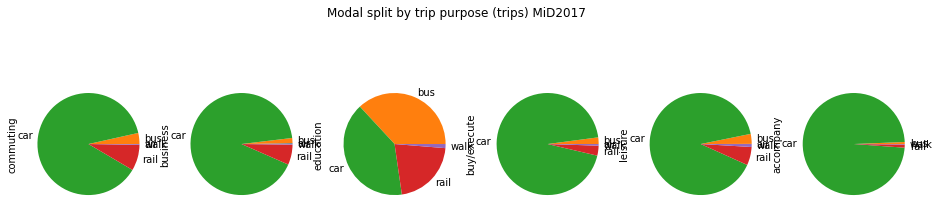

In [107]:
mid_val.groupby('mode_agg').sum()[purposes].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (trips) MiD2017')

array([<AxesSubplot:ylabel='(commuting, volume)'>,
       <AxesSubplot:ylabel='(business, volume)'>,
       <AxesSubplot:ylabel='(education, volume)'>,
       <AxesSubplot:ylabel='(buy/execute, volume)'>,
       <AxesSubplot:ylabel='(leisure, volume)'>,
       <AxesSubplot:ylabel='(accompany, volume)'>], dtype=object)

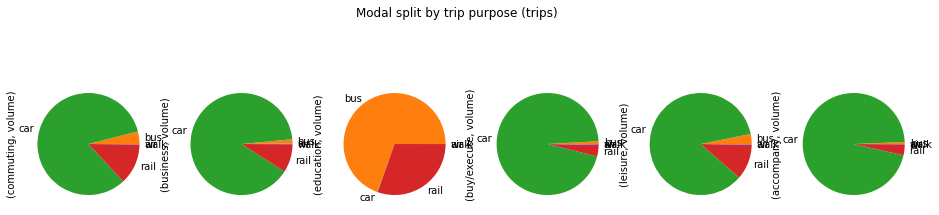

In [108]:
od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose (trips)')
#plt.savefig(output_path + scenario + '/' + 'modal_split_trips_segmented.png', dpi=300)

In [109]:
# MiD mode shares in percent
(mid_val.groupby('mode_agg').sum() /
 mid_val[purposes].sum() * 100)[purposes].round(2)

,commuting,business,education,buy/execute,leisure,accompany
mode_agg,,,,,,
air,0.00,0.26,0.00,0.01,0.05,0.00
bus,3.49,1.64,36.90,2.09,3.15,0.64
car,88.03,91.52,40.39,94.24,90.08,98.22
rail,8.22,6.38,21.42,3.14,5.79,0.98
walk,0.26,0.20,1.29,0.53,0.93,0.16


In [110]:
# Model mode shares in percent
(od_sum[[(seg, 'volume') for seg in purposes]].groupby(level=2).sum() /
 od_sum[[(seg, 'volume') for seg in purposes]].sum() * 100).round(2)

segment,commuting,business,education,buy/execute,leisure,accompany
sum,volume,volume,volume,volume,volume,volume
mode,,,,,,
air,0.00,0.18,0.00,0.00,0.01,0.00
bus,3.96,1.31,69.50,0.88,3.16,0.62
car,82.96,89.42,0.09,95.21,85.42,95.84
rail,12.95,9.03,30.39,3.61,11.16,3.45
walk,0.13,0.06,0.01,0.29,0.24,0.10


In [111]:
# MiD2017 mode shares - total
mid_val['sum'] = mid_val[purposes].sum(axis=1)
(mid_val.groupby('mode_agg').agg({'sum': 'sum'}) / mid_val['sum'].sum() * 100).round(2)

,sum
mode_agg,
air,0.03
bus,4.12
car,89.24
rail,6.03
walk,0.57


In [112]:
# Model mode shares in percent - total
(od_sum['root'].groupby(level=2).sum() / od_sum['root'].sum() * 100).round(2)

sum,volume,length,pkm
mode,,,
air,0.01,9.11,0.07
bus,2.49,19.52,2.14
car,88.36,36.74,89.95
rail,8.94,34.62,7.81
walk,0.20,0.01,0.03


array([<AxesSubplot:ylabel='(commuting, pkm)'>,
       <AxesSubplot:ylabel='(business, pkm)'>,
       <AxesSubplot:ylabel='(education, pkm)'>,
       <AxesSubplot:ylabel='(buy/execute, pkm)'>,
       <AxesSubplot:ylabel='(leisure, pkm)'>,
       <AxesSubplot:ylabel='(accompany, pkm)'>], dtype=object)

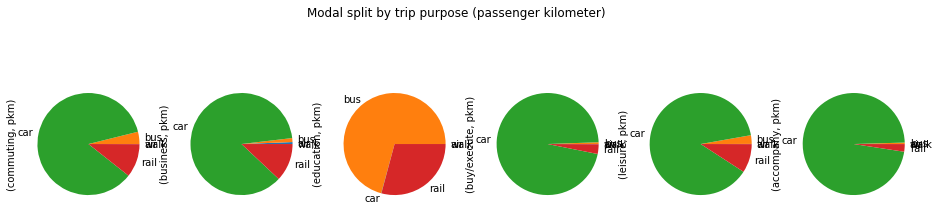

In [113]:
od_sum[[(seg, 'pkm') for seg in purposes]].groupby(level=2).sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose (passenger kilometer)')
#plt.savefig(output_path + scenario + '/' + 'modal_split_pkm_segmented.png', dpi=300)

In [114]:
# Normalise model volumes
od = od_sum[[(seg, 'volume') for seg in purposes]
           ].unstack('mode').fillna(0).droplevel('sum', axis=1)
od = (od-od.min())/(od.max()-od.min()).max()
# Scale model and validation data to the same level
od = od * (vp2017.mean().mean() / od.mean().mean())

<AxesSubplot:xlabel='distance [km]'>

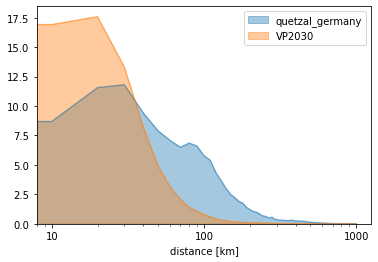

In [115]:
# Sum up volumes of the model and VP2030
vol_df = pd.DataFrame(od[[c for c in od.columns
                          if c[0] in purposes and c[1]!='walk']
                        ].sum(axis=1).rename('quetzal_germany'))
vol_df['VP2030'] = vp2017[[c for c in vp2017.columns
                           if c[0].startswith('Fz') and c[1]!='walk']
                         ].sum(axis=1)
# Create distance classes
dist_classes = list(range(0, 1011, 10))
vol_df['distance [km]'] = pd.cut(vol_df.merge(distances, how='left',
                                               left_index=True, right_index=True
                                              )['length'],
                                 bins=dist_classes,
                                 labels=dist_classes[:-1])

# Scaled normalised volumes: erronous, don't use them
vol_df.groupby('distance [km]').agg({'quetzal_germany': 'sum', 'VP2030': 'sum'}
                                   ).plot(kind='area', stacked=False, alpha=.4,logx=True)

In [116]:
# Cut matrices into distance classes
od['bins'] = pd.cut(od.merge(distances, how='left',
                             left_on=['origin', 'destination'],
                             right_index=True)['length'],
                    bins=bins, labels=labels)
vp2017['bins'] = pd.cut(vp2017.merge(distances, how='left',
                                     left_index=True,
                                     right_index=True)['length'],
                        bins=bins, labels=labels)

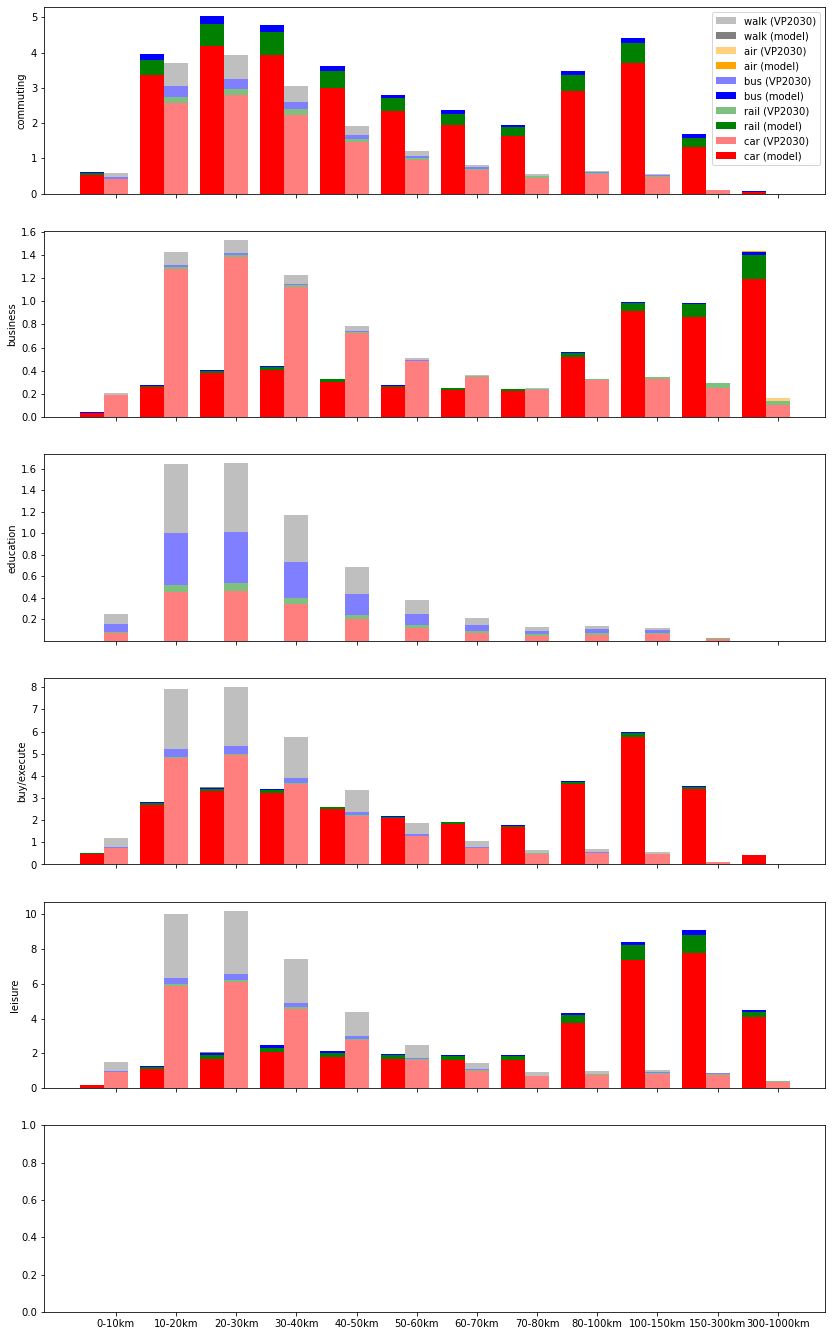

In [117]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
width = 0.4
ind = np.arange(len(labels))
modes = ['car', 'rail', 'bus', 'air', 'walk']
colors = ['red', 'green', 'blue', 'orange', 'grey']
od_binned = od.groupby('bins').sum()
vp_binned = vp2017.groupby('bins').sum()
for seg in range(len(purposes[:-1])):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    vp_vols = [vp_binned[(p_dict[purposes[seg]], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            vp_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            vp_bottom = sum(vp_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(vp_vols[i]), bottom=vp_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
#plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030.png', dpi=300)

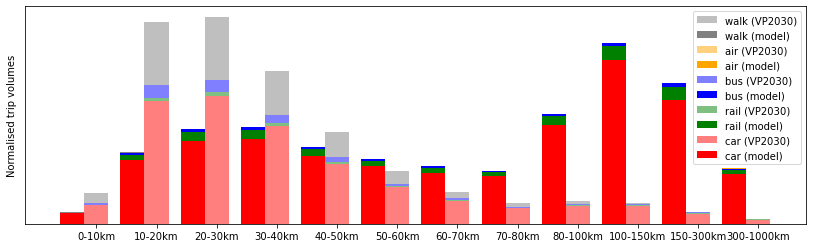

In [118]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        vp_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        vp_bottom = sum(vp_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, vp_vols[i], bottom=vp_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
ax.set_ylabel('Normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
#plt.savefig(output_path + scenario + '/' + 'distance_validation_VP2030_all.png', dpi=300)

In [119]:
# Normalise and scale the dataset
mid2017 = (mid2017-mid2017.min())/(mid2017.max()-mid2017.min()).max()
mid2017 = mid2017 * (od_binned.mean().mean()
                     / mid2017.mean().mean())

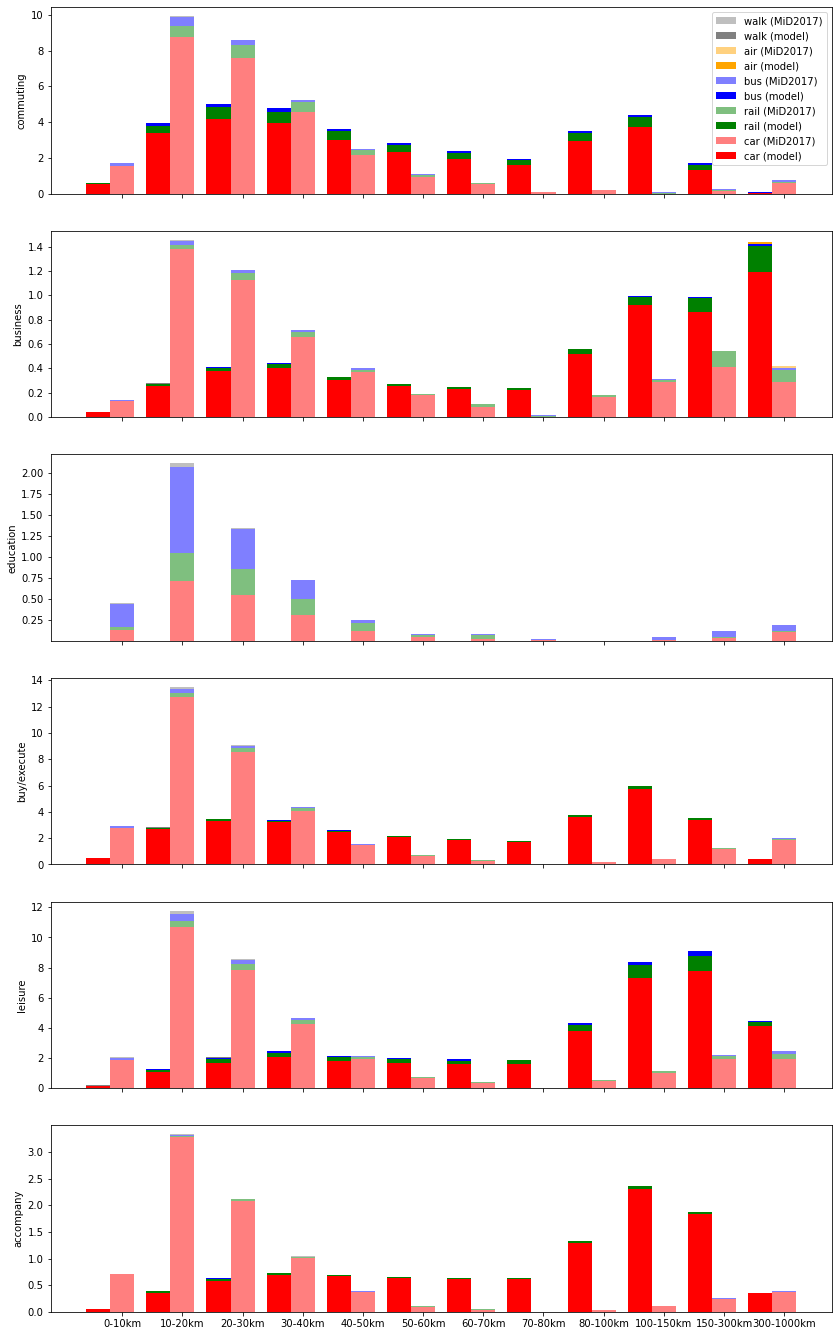

In [120]:
# Plot distance and mode distribution by segment
fig, ax = plt.subplots(nrows=len(purposes), ncols=1,
                       figsize=(14,len(purposes)*4),
                       sharex='all', sharey='row')
for seg in range(len(purposes)):
    model_vols = [od_binned[(purposes[seg], mode)] for mode in modes]
    mid_vols = [mid2017[(purposes[seg], mode)] for mode in modes]
    for i in range(len(modes)):
        if i==0:
            model_bottom = 0
            mid_bottom = 0
        else:
            model_bottom = sum(model_vols[:i])
            mid_bottom = sum(mid_vols[:i])
        ax[seg].bar(ind, np.array(model_vols[i]), bottom=model_bottom,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
        ax[seg].bar(ind+width, np.array(mid_vols[i]), bottom=mid_bottom, alpha=.5,
                    width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax[seg].set_ylabel(purposes[seg])
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h[::-1], l[::-1])
#plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017.png', dpi=300)

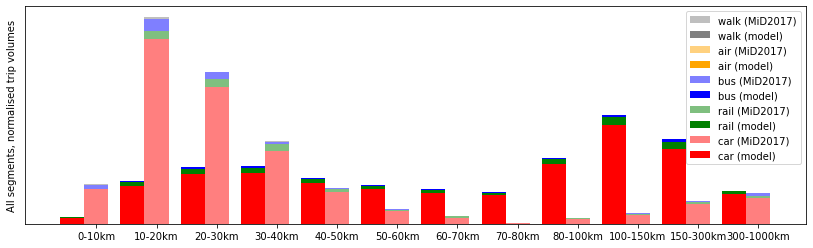

In [121]:
# Plot distance and mode distribution all together
fig, ax = plt.subplots(figsize=(14,4))
width = 0.4
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        model_bottom = 0
        mid_bottom = 0
    else:
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (model)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
ax.set_ylabel('All segments, normalised trip volumes')
ax.set_yticks([])
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l[::-1])
#plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_all.png', dpi=300)

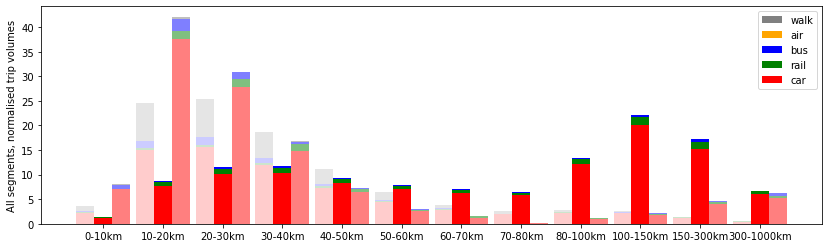

In [122]:
# Plot distance and mode distribution for all three data sources
fig, ax = plt.subplots(figsize=(14,4))
width = 0.3
vp_vols = vp_binned.stack().sum(axis=1).unstack()[modes].T.values
model_vols = od_binned.stack().sum(axis=1).unstack()[modes].T.values
mid_vols = mid2017.stack().sum(axis=1).unstack()[modes].T.values
for i in range(len(modes)):
    if i==0:
        vp_bottom = 0
        model_bottom = 0
        mid_bottom = 0
    else:
        vp_bottom = sum(vp_vols[:i])
        model_bottom = sum(model_vols[:i])
        mid_bottom = sum(mid_vols[:i])
    ax.bar(ind-width, vp_vols[i], bottom=vp_bottom, alpha=.2,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (VP2030)')
    ax.bar(ind+width, mid_vols[i], bottom=mid_bottom, alpha=.5,
           width=width, tick_label=labels, color=colors[i], label=modes[i]+' (MiD2017)')
    ax.bar(ind, model_vols[i], bottom=model_bottom,
           width=width, tick_label=labels, color=colors[i], label=modes[i])#+' (model)')
ax.set_ylabel('All segments, normalised trip volumes')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-3], l[::-3])
#plt.savefig(output_path + scenario + '/' + 'distance_validation_MiD2017_VP2030_all.png', dpi=300)

In [123]:
# Difference in the largest distance segment in % to MiD2017
(sum(model_vols.T[-1]) - sum(mid_vols.T[-1])) / sum(mid_vols.T[-1])

0.08111065494397288

In [124]:
od_sum.xs('car', level=2)[('root', 'volume')].sum() / 1e6

20635.549894462514